In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
df=pd.read_csv('../../Database/high_diamond_ranked_10min.csv',index_col=False)
scaler=StandardScaler()


In [3]:
y=df['blueWins']
X=scaler.fit_transform(df.drop(['blueWins'],axis=1))

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold
from sklearn.utils import class_weight
import joblib

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [13]:
def gridSearch(model,params,X,Y,VALID_SIZE,FOLDS=2):
    skf = KFold(n_splits=FOLDS)
    scoring = {'AUC': 'roc_auc', 'Accuracy':'accuracy'}    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True)
    gs = GridSearchCV(model, scoring=scoring,cv=skf, param_grid=params, return_train_score=True, n_jobs=-1,refit='AUC')
    gs.fit(X_train, Y_train)
    print(gs.best_estimator_)
    print(np.abs(gs.best_score_))
    return gs,X_test,Y_test

In [11]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import scikitplot as skplt#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

def hiper(X,Y,band):
    #Validamos el modelo
    Folds = 10
    skf = KFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0

    for k in band:
        Acc = []
        Auc= []

        for j, (train, test) in enumerate(skf.split(X, Y)):
            Xtrain= X[train,:]
            Ytrain = Y[train]
            Xtest = X[test, :]
            Ytest = Y[test]
            #Normalizamos los datos
            scaler = StandardScaler().fit(X= Xtrain)       
            Xtrain = scaler.transform(Xtrain)
            Xtest = scaler.transform(Xtest)
            model = KDEClassifier(bandwidth=k, kernel='gaussian')

            model.fit(X=Xtrain, y=Ytrain)
            Yest = model.predict_proba(Xtest)
            Yest=np.nan_to_num(Yest)
            Acc.append(balanced_accuracy_score(Ytest,np.argmax(Yest, 1)))
            aux=roc_auc_score(Ytest,Yest[:,1])
            Auc.append(aux)
    
        resultados.loc[idx,'BandWith'] = k
        resultados.loc[idx,'AUC medio'] = np.mean(Auc)
        resultados.loc[idx,'AUC intervalo de confianza'] = np.std(Auc)
        resultados.loc[idx,'Accuracy medio'] = np.mean(Acc)
        resultados.loc[idx,'Accuracy intervalo de confianza'] = np.std(Acc)
        idx=idx+1
    
    return (resultados)

def experimentar(X,Y):
    #Validamos el modelo
    Folds = 10
    skf = KFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0
    Acc = []
    Auc= []

    for j, (train, test) in enumerate(skf.split(X, Y)):
        Xtrain= X[train,:]
        Ytrain = Y[train]
        Xtest = X[test, :]
        Ytest = Y[test]
        #Normalizamos los datos
        scaler = StandardScaler().fit(X= Xtrain)       
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        model = KDEClassifier(bandwidth=1.85, kernel='gaussian')
        model.fit(X=Xtrain, y=Ytrain)
        Yest = model.predict_proba(Xtest)
        Yest=np.nan_to_num(Yest)
        Acc.append(balanced_accuracy_score(Ytest,np.argmax(Yest, 1)))
        aux=roc_auc_score(Ytest,Yest[:,1])
        Auc.append(aux)
    skplt.metrics.plot_confusion_matrix(Ytest,np.argmax(Yest, 1),normalize=True) #matriz de confusión
    skplt.metrics.plot_roc(Ytest,Yest)
    print(classification_report(Ytest,np.argmax(Yest, 1)))
    
    resultados.loc[idx,'AUC medio'] = np.mean(Auc)
    resultados.loc[idx,'AUC intervalo de confianza'] = np.std(Auc)
    resultados.loc[idx,'Accuracy medio'] = np.mean(Acc)
    resultados.loc[idx,'Accuracy intervalo de confianza'] = np.std(Acc)
    return (resultados)

In [10]:
hiper(X,y,np.arange(0.05,2,.2))

<ipython-input-5-5b9b2a44f081>:30: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)
<ipython-input-5-5b9b2a44f081>:30: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)
<ipython-input-5-5b9b2a44f081>:30: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)
<ipython-input-5-5b9b2a44f081>:30: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)
<ipython-input-5-5b9b2a44f081>:30: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)
<ipython-input-5-5b9b2a44f081>:30: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)
<ipython-input-5-5b9b2a44f081>:30: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)
<ipython-input-5-5b9b2a44f0

,BandWith,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.05,0.510216,0.011937,0.507686,0.011249
1,0.25,0.580094,0.020810,0.559028,0.014521
2,0.45,0.651336,0.013587,0.613394,0.012240
3,0.65,0.701493,0.013301,0.646087,0.010901
4,0.85,0.729195,0.012915,0.671213,0.008683
5,1.05,0.758970,0.011550,0.693278,0.009927
6,1.25,0.782463,0.010661,0.712602,0.008458
7,1.45,0.795726,0.010654,0.720497,0.009724
8,1.65,0.802250,0.010609,0.722909,0.009330
9,1.85,0.805607,0.010482,0.724182,0.009252


              precision    recall  f1-score   support

           0       0.74      0.72      0.73       516
           1       0.70      0.72      0.71       471

    accuracy                           0.72       987
   macro avg       0.72      0.72      0.72       987
weighted avg       0.72      0.72      0.72       987



,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.805607,0.010482,0.724182,0.009252


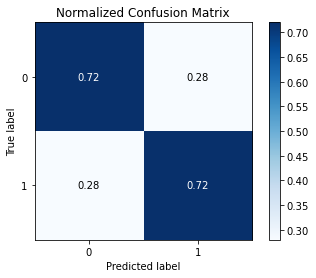

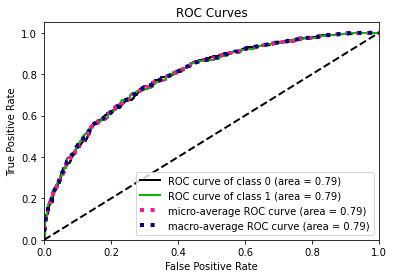

In [13]:
experimentar(X,y)